# SOM

In [ ]:
import jetutils
import rustworkx as rx
from jetutils.jet_finding import *
from jetutils.definitions import *
from jetutils.anyspell import mask_from_spells_pl
from jetutils.plots import *
from jetutils.clustering import *
from jetutils.data import *
from jetutils.jet_finding import JetFindingExperiment, get_double_jet_index, find_all_jets
from jetutils.plots import plot_seasonal, plot_trends, trends_and_pvalues, num2tex, COLORS, periodic_rolling_pl
from jetutils.data import DataHandler, flatten_by, standardize, metadata_from_da, find_spot 
from pathlib import Path
import colormaps

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import glob
import os
import seaborn as sns
import autoreload
import matplotlib.gridspec as gridspec
import calendar
from datetime import datetime, timedelta
from string import ascii_lowercase
import colormaps
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm, trange
from jetutils.anyspell import get_persistent_spell_times_from_som
from jetutils.clustering import RAW_REALSPACE, Experiment, labels_to_centers, labels_to_mask, timeseries_on_map
from jetutils.definitions import (
    DATADIR,
    FIGURES,
    TIMERANGE,
    PRETTIER_VARNAME,
    UNITS,
    normalize,
    xarray_to_polars,
    get_region,
)
from jetutils.jet_finding import JetFindingExperiment, get_double_jet_index, compute_jet_props, average_jet_categories, is_polar_gmix, find_all_jets, compute_widths, jet_position_as_da
from jetutils.plots import Clusterplot, honeycomb_panel, TEXTWIDTH_IN, COLORS, infer_direction
from simpsom_dask import plots as splots
from simpsom_dask.neighborhoods import Neighborhoods
from scipy.stats import linregress
from sklearn.metrics import pairwise_distances
from tqdm import trange
import matplotlib.colors as mcolors

%matplotlib inline
print(jetutils.__file__)

Found config override file at  /home/mabeling/.jetutils.ini
Guessed N_WORKERS :  256
Guessed MEMORY_LIMIT :  8000
/home/mabeling/Jetutils-NP/jetutils/__init__.py


In [ ]:
basepath = "/scratch2/mabeling/data/ERA5/plev/high_wind/6H/data/combined"
season_months = {
    "DJF": [12, 1, 2],
    "MAM": [3, 4, 5],
    "JJA": [6, 7, 8],
    "SON": [9, 10, 11],
}
season = "DJF" #'JJA' 'DJF' 'all'

In [ ]:
ds = xr.open_dataset(basepath     + "/uvtths_plevhigh_1959_2022.nc")
exp = JetFindingExperiment(DataHandler.from_basepath_and_da(basepath, ds, save_da=True)) 

In [4]:
all_jets_one_df = exp.find_jets()
time = "month"
#thresh = "06"
init = "def"
all_jets_one_df_cats = exp.categorize_jets(feature_names=("s", "theta"), mode=time)
props_as_df_uncat = exp.props_as_df(False)
jet_pos_da = exp.jet_position_as_da()
props_as_df = pl.read_parquet(exp.path.joinpath("props_as_df.parquet"))
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
props_as_df_winter = props_as_df.filter(pl.col("time").dt.month().is_in([12, 1, 2]))
# 2 cats for winter + one cat for all summer jets
def categorize_jets_three(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns(
        pl.when(pl.col("time").dt.month().is_in([12, 1, 2, 3]))
        .then(pl.col("jet"))                # keep original jet in winter
        .otherwise(pl.lit("ALL"))           # collapse into ALL otherwise
        .alias("jet")
    )
props_as_df_test = categorize_jets_three(props_as_df)

In [7]:
ds = xr.open_dataset(basepath     + "/uvtths_plevhigh_1959_2022.nc")
if season.lower() != "all":
    ds = ds.sel(time=ds.time.dt.season == season)

In [8]:
ds = ds.assign_coords(lon=((360 + (ds.lon % 360)) % 360)).sortby("lon")
#ds = ds.roll(lon=int(len(ds['lon']) / 2),roll_coords=True)

In [13]:
exp_s = Experiment(DataHandler.from_basepath_and_da("/scratch2/mabeling/data/ERA5/plev/high_wind/6H/data/combined", ds['s'], save_da=True))

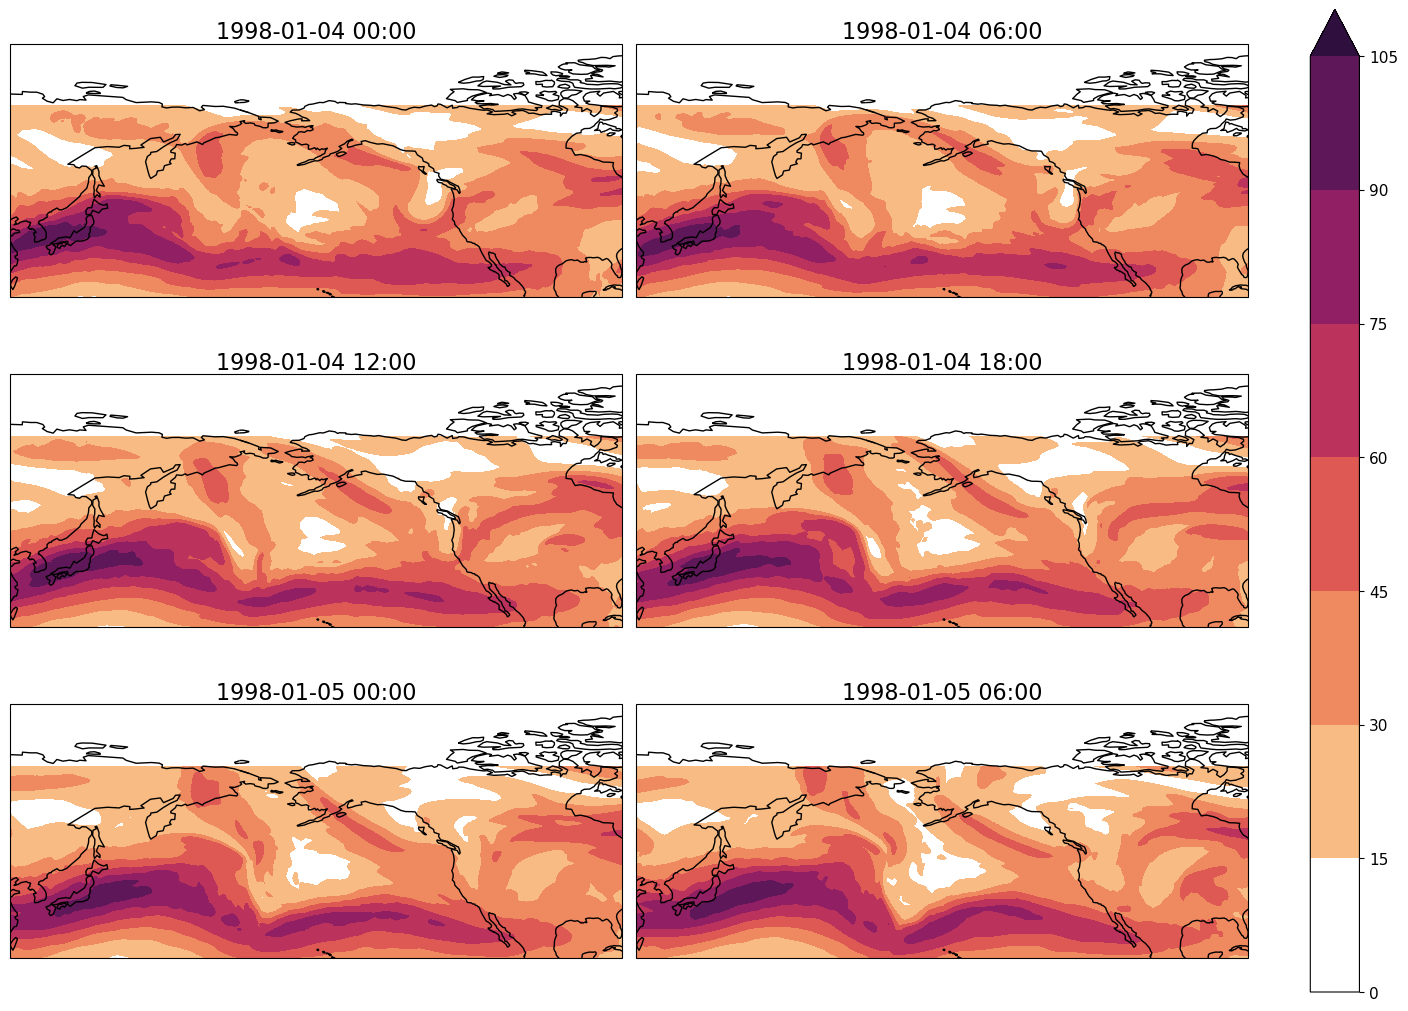

In [17]:
da = exp_s.da
target_date = '1998-01-04'
time_index = np.where(da.time.dt.date == pd.to_datetime(target_date).date())[0]
i = time_index[0] - 3
clu = Clusterplot(3, 2, get_region(da))
i =  int(time_index[0])
is_ = np.arange(i, i + 6)
formatted_titles = [pd.to_datetime(t).strftime('%Y-%m-%d %H:%M') for t in da.time[is_].values]
contour_result = clu.add_contourf(da[is_], titles=formatted_titles, levels=7, cmap=colormaps.matter, transparify=1) #,draw_cbar=False)

fig = plt.gcf()
fig.set_size_inches(14, 10)

#cbar_ax = fig.add_axes([0.15, 0.50, 0.7, 0.03])  
#cbar = fig.colorbar(
#    contour_result[0],     
#    cax=cbar_ax,          is
#    orientation='horizontal')
#cbar.set_label('Wind speed [m/s]')

plt.savefig(f"/home/mabeling/MasterThesis/plots/maps/{target_date}.png", bbox_inches='tight', dpi=300)

In [ ]:
metric = "euclidean"
nx = 4
ny = 4

exp_s = Experiment(DataHandler.from_basepath_and_da("/scratch2/mabeling/data/ERA5/plev/high_wind/6H/data/combined", ds['s'], save_da=True))

ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")

net, centers, labels = exp_s.som_cluster(
    nx,
    ny,
    activation_distance=metric,
    return_type=RAW_REALSPACE,
    force=False,
    sigma=2, #orig 2
    sigmaN=1e-5,
    train_kwargs=dict(num_epochs=20),
    init="pca"
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")

labels_da = xr.DataArray(labels, coords={"time": exp_s.da.time}, dims="time")
ds = exp.ds
if season == "all":
    ds_center = labels_to_centers(labels_da, ds)
else:
    # convert labels to DataArray with full-year time coordinates
    #djf_mask = exp_s.da.time.dt.season == season
    #ds_djf = ds.sel(time=djf_mask)
    #labels_djf = labels_da.sel(time=djf_mask)
    ds = ds.sel(time=ds.time.dt.season == season)
    ds_center = labels_to_centers(labels, ds)
    #ds_center = labels_to_centers(labels_djf, ds_djf)
ds_center.to_netcdf(ds_center_path)

mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s.da.time, "cluster": np.arange(net.n_nodes)})

In [14]:
exp_s.path

PosixPath('/scratch2/mabeling/data/ERA5/plev/high_wind/6H/data/combined/14')

DJF


100%|██████████| 16/16 [00:00<00:00, 364.35it/s]


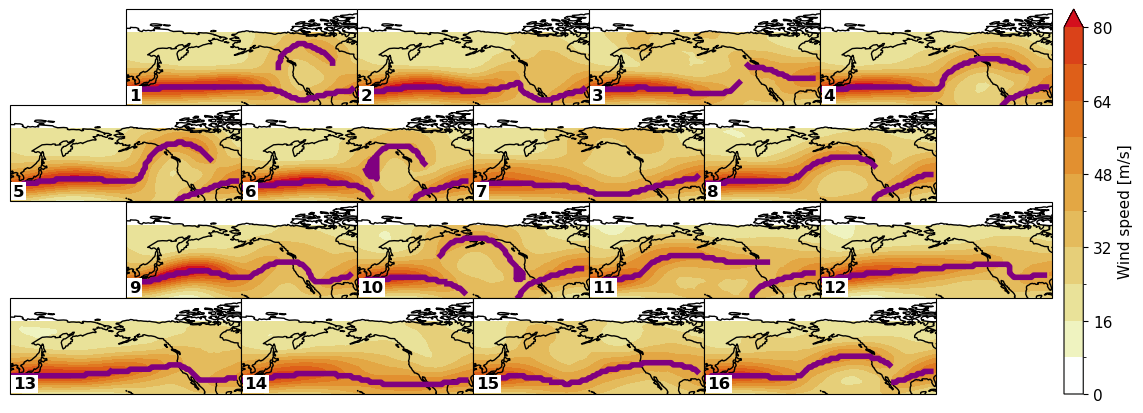

In [15]:
ds_center = ds_center.load()
print(season)
b_thresh=18
a_thresh=0.6 #def 0.6

# Convert to 0–360 longitude frame, also SOM centers consistent
ds_center = ds_center.assign_coords(lon=((ds_center.lon + 360) % 360)).sortby("lon")

centers = centers.assign_coords(lon=((centers.lon + 360) % 360)).sortby("lon")

centers_all_jets = find_all_jets(ds_center, base_s_thresh=b_thresh, alignment_thresh=a_thresh)#int_thresh_factor=0.5)
centers_all_jets = centers_all_jets.with_columns(((pl.col("lon") + 360) % 360).alias("lon"))


centers_all_jets = is_polar_gmix(centers_all_jets,("lon", "lat", "lev"), n_components=2, n_init=100)
if "index" in centers_all_jets.columns:
    centers_all_jets = centers_all_jets.drop("index")

new_id = []
for clu, jets in centers_all_jets.group_by("cluster", maintain_order=True):
    njets = jets["jet ID"].n_unique()
    for idx, jet in jets.group_by("jet ID", maintain_order=True):
        new_jet_id = jet.with_columns(
            pl.col("jet ID")
            + (pl.col("is_polar") > 0.5)
            .cast(pl.UInt16)
            .diff()
            .abs()
            .fill_null(0)
            .cum_sum()
            .cast(pl.UInt32)
            * njets
        )
        njets = jets["jet ID"].n_unique() - 1 + new_jet_id["jet ID"].n_unique()
        new_id.append(new_jet_id.sort("lon"))
centers_all_jets = pl.concat(new_id)

# FILTER
centers_all_jets = centers_all_jets.filter(
    pl.len().over(["cluster", "jet ID"]) >= 2.1)

centers_props_uncat = compute_jet_props(centers_all_jets)
centers_props = average_jet_categories(centers_props_uncat, polar_cutoff=0.001)

# Plot
clu = Clusterplot(net.y, net.x, get_region(ds), honeycomb=True, numbering=True)
_ = clu.add_contourf(
    centers,
    cmap=colormaps.cet_l_wyor,
    levels=10,
    #levels=[0, 8, 16, 24, 32, 40],
    cbar_kwargs={"label": "Wind speed [m/s]", "pad": 0.01}
)

for indexer, jet in centers_all_jets.group_by(["cluster", "jet ID"], maintain_order=True):
    ax = clu.axes[indexer[0]]
    is_polar = jet["is_polar"].mean() >= 0.35
    color =  'purple' #COLORS[2 - int(is_polar)]
    ax.plot(
        *jet[["lon", "lat"]].to_numpy().T,
        lw=4,
        color=color,
        #alpha=0.8,
        transform=ccrs.PlateCarree())
clu.fig.set_size_inches(32, 5)
clu.resize_relative([0.5, 1])
plt.savefig(f"/home/mabeling/MasterThesis/plots/maps/JetMaps_{season}_{b_thresh}_{a_thresh}.pdf", bbox_inches="tight", pad_inches=0.1)#  dpi=1000, 

In [15]:
def check_som_longitude_continuity(centers, lat_sel=None):
    """
    Visual + numeric diagnostics to verify that SOM centers are continuous across the 180° longitude seam.

    Parameters
    ----------
    centers : xr.DataArray
        SOM cluster centers with dims ('cluster', 'lat', 'lon')
    lat_sel : float, optional
        Latitude for the zonal slice plot (defaults to equator)

    Returns
    -------
    corrs : list of float
        Correlation coefficients between first and last longitude for each cluster.
    """

    n_clusters = centers.sizes["cluster"]
    ncols = int(np.ceil(np.sqrt(n_clusters)))
    nrows = int(np.ceil(n_clusters / ncols))

    # Plot all cluster maps
    fig, axes = plt.subplots(
        nrows, ncols, figsize=(3.5*ncols, 2.8*nrows),
        subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180))
    )
    axes = np.ravel(axes)

    corrs = []
    for i in range(n_clusters):
        da = centers.isel(cluster=i)
        # edge correlation
        a = da.isel(lon=-1).values
        b = da.isel(lon=0).values
        corr = np.corrcoef(a.flatten(), b.flatten())[0, 1]
        corrs.append(corr)

        da.plot(
            ax=axes[i],
            transform=ccrs.PlateCarree(),
            cmap="RdBu_r",
            center=0,
            robust=True,
            add_colorbar=False
        )
        axes[i].coastlines()
        axes[i].set_title(f"Cluster {i} (corr={corr:.2f})", fontsize=9)

    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    fig.suptitle("SOM Cluster Centers — Check for Seam at 180°", fontsize=15, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Zonal section for one cluster (default: 0)
    if lat_sel is None:
        lat_sel = float(centers.lat.sel(lat=centers.lat.mean(), method="nearest"))

    cluster_idx = 0
    da_line = centers.isel(cluster=cluster_idx).sel(lat=lat_sel, method="nearest")

    plt.figure(figsize=(7, 3))
    plt.plot(da_line.lon, da_line, lw=2)
    plt.axvline(180, color="k", ls="--")
    plt.title(f"Zonal section at lat={lat_sel:.1f}°, cluster {cluster_idx}")
    plt.xlabel("Longitude")
    plt.ylabel("Field value")
    plt.grid(True)
    plt.show()

    # summary
    print("\nEdge correlations (lon=-180 vs 180):")
    for i, c in enumerate(corrs):
        flag = "√" if c > 0.7 else "⚠️"
        print(f"  Cluster {i:2d}: {c:.2f} {flag}")

    return corrs

def seam_rms_diff(centers):
    lon_first = centers.isel(lon=0)
    lon_last = centers.isel(lon=-1)
    rms = np.sqrt(((lon_first - lon_last)**2).mean(("lat", "cluster")))
    print(f"RMS edge mismatch: {rms.values:.4e}")
    return rms


In [ ]:
#centers_plotti = ds_center["s"].sortby("lon")
#corrs = check_som_longitude_continuity(centers_plotti)

In [28]:
# Find the index 
da = exp_s.da
target_date = '2013-06-18'
time_index = np.where(da.time.dt.date == pd.to_datetime(target_date).date())[0]

if len(time_index) > 0:
    i = time_index[0] - 3  # Start 3 time steps before
    print(f"Found Date at index: {time_index[0]}")
    
    # Show the 6 time steps we'll plot
    is_ = np.arange(i, i + 6)
    print("Will plot these dates:")
    for idx in is_:
        print(f"  {pd.to_datetime(da.time[idx].values).strftime('%Y-%m-%d %H:%M')}")
else:
    print("Date not found, trying nearby dates...")
    # Try to find any date in July 2022
    july_2022 = da.time[(da.time.dt.year == 2022) & (da.time.dt.month == 7)]
    if len(july_2022) > 0:
        # Use the first available date in July 2022
        first_july_idx = np.where(da.time == july_2022[0])[0][0]
        i = first_july_idx - 3
        print(f"Using {pd.to_datetime(july_2022[0].values).strftime('%Y-%m-%d')} instead")
    else:
        print("No data found")
        i = 23337 - 3  # Fall back to original

Found Date at index: 19940
Will plot these dates:
  2013-06-17 06:00
  2013-06-17 12:00
  2013-06-17 18:00
  2013-06-18 00:00
  2013-06-18 06:00
  2013-06-18 12:00


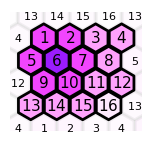

<Figure size 640x480 with 0 Axes>

In [ ]:
#nx = 4
#ny = 4
outer_grid, inner_grid, coords, outermask = splots.create_outer_grid(nx, ny)
nei = Neighborhoods(nx, ny, "hexagons", PBC=True)

cmap = colormaps.cet_l_bmw
cmap = LinearSegmentedColormap.from_list("hoho", cmap(np.linspace(0.45, 1.0, cmap.N // 2)))

from_ = 5

feature = nei.distances[from_, outer_grid.flatten()]

edgecolors = np.full(len(coords), 'black', dtype=object)
edgecolors[outermask] = 'gray'
alphas = np.ones(len(coords))
alphas[outermask] = 0.05

fig, ax = splots.plot_map(
    coords, feature, feature2=None,#'hexagons',
    draw_cbar=False, figsize=(0.5 * TEXTWIDTH_IN, 1.55),
    show=False, edgecolors='black', cmap=cmap,
    alphas=alphas, linewidths=2,
)

xlims = [np.amin(coords[~outermask][:, 0]) - 0.8, np.amax(coords[~outermask][:, 0]) + 0.8]
ylims = [np.amin(coords[~outermask][:, 1]) - 1, np.amax(coords[~outermask][:, 1]) + 1]

for i, c in enumerate(coords):
    x, y = c
    fontsize = 8 if outermask[i] else 11
    if x > xlims[0] and x < xlims[-1] and y > ylims[0] and y < ylims[-1]:
        ax.text(x, y, f'${outer_grid.flatten()[i] + 1}$', va='center', ha='center', color="black", fontsize=fontsize)

ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_aspect("equal")
plt.show()
plt.savefig("/home/mabeling/MasterThesis/plots/som/clusternumbers.png")

/home/mabeling/miniforge3/envs/env12/lib/python3.12/site-packages/simpsom_dask/plots.py:36: RuntimeWarning: divide by zero encountered in log10
  sym = sym and np.abs(np.log10(np.abs(max_)) - np.log10(np.abs(min_))) <= 2
/home/mabeling/miniforge3/envs/env12/lib/python3.12/site-packages/simpsom_dask/plots.py:36: RuntimeWarning: invalid value encountered in scalar subtract
  sym = sym and np.abs(np.log10(np.abs(max_)) - np.log10(np.abs(min_))) <= 2


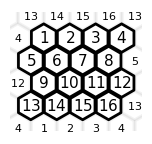

In [22]:
outer_grid, inner_grid, coords, outermask = splots.create_outer_grid(nx, ny)
nei = Neighborhoods(nx, ny, "hexagons", PBC=True)
cmap = colormaps.cet_l_bmw
cmap = LinearSegmentedColormap.from_list("hoho", cmap(np.linspace(0.45, 1.0, cmap.N // 2)))
from_ = 5
# distances = nei.distances[from_, outer_grid]
distances = np.full(len(coords), np.nan)
edgecolors = np.full(len(coords), 'black', dtype=object)
edgecolors[outermask] = 'gray'
alphas = np.ones(len(coords))
alphas[outermask] = 0.05
fig, ax = splots.plot_map(
    coords, distances,  feature2 = None, #'hexagons',
    draw_cbar=False, figsize=(0.5 * TEXTWIDTH_IN, 1.55), 
    show=False, edgecolors = 'black', cmap=None,
    alphas=alphas, linewidths=2,
)
xlims = [np.amin(coords[~outermask][:, 0]) - 0.8, np.amax(coords[~outermask][:, 0]) + 0.8]
ylims = [np.amin(coords[~outermask][:, 1]) - 1, np.amax(coords[~outermask][:, 1]) + 1]
for i, c in enumerate(coords):
    x, y = c
    # textcolor = "white" if distances[i] < 2 else "black"
    fontsize = 8 if outermask[i] else 11
    if x > xlims[0] and x < xlims[-1] and y > ylims[0] and y < ylims[-1]: 
        ax.text(x, y, f'${outer_grid.flatten()[i] + 1}$', va='center', ha='center', color="black", fontsize=fontsize)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_aspect("equal")
plt.savefig("/home/mabeling/MasterThesis/plots/som/clusterswhite.png")

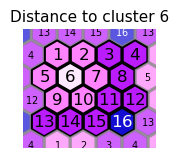

In [23]:
outer_grid, inner_grid, coords, outermask = splots.create_outer_grid(nx, ny)
nei = Neighborhoods(nx, nx, "hexagons", PBC=True)
cmap = colormaps.cet_l_bmw_r
cmap = LinearSegmentedColormap.from_list("hoho", cmap(np.linspace(0.0, 0.75, cmap.N // 2)))
from_ = 5 #9
distances = nei.distances[from_, outer_grid]
# distances = np.full(len(coords), np.nan)
edgecolors = np.full(len(coords), "black", dtype=object)
edgecolors[outermask] = 'gray'
alphas = np.ones(len(coords))
alphas[outermask] = 0.7
fig, ax = splots.plot_map(
    coords, distances, feature2 = None, #'hexagons',
    draw_cbar=False, figsize=(0.5 * TEXTWIDTH_IN, 1.55), 
    show=False, edgecolors = edgecolors, cmap=cmap,
    alphas=alphas, linewidths=1.5,
)
xlims = [np.amin(coords[~outermask][:, 0]) - 0.8, np.amax(coords[~outermask][:, 0]) + 0.8]
ylims = [np.amin(coords[~outermask][:, 1]) - 1, np.amax(coords[~outermask][:, 1]) + 1]
for i, c in enumerate(coords):
    x, y = c
    textcolor = "white" if distances[i] > 2 else "black"
    fontsize = 7 if outermask[i] else 12
    if x > xlims[0] and x < xlims[-1] and y > ylims[0] and y < ylims[-1]: 
        text_obj = ax.text(x, y, f'${outer_grid.flatten()[i] + 1}$', va='center', ha='center', color=textcolor, fontsize=fontsize)
        text_obj.set_clip_on(True) 
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_aspect("equal")
ax.set_title(f"Distance to cluster {from_ + 1}", pad=5)
#plt.subplots_adjust(bottom=0.01)
plt.savefig("/home/mabeling/MasterThesis/plots/som/clusterdistance.png")

(<Figure size 560x400 with 2 Axes>, <Axes: >)

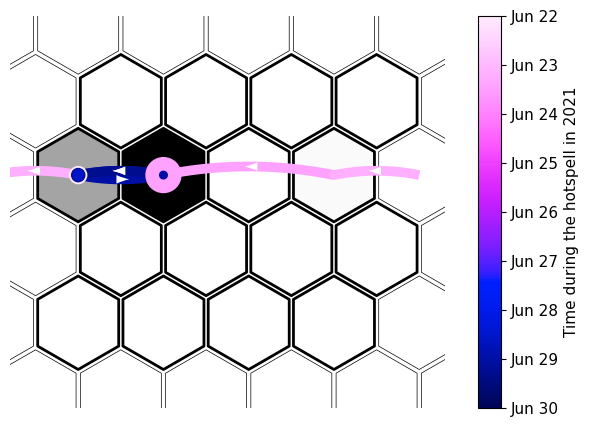

In [19]:
period = pd.date_range("20210622", "20210630", freq="6h")
splots.plt_traj_hotspell(nx, ny, period, labels)

(<Figure size 560x400 with 2 Axes>, <Axes: >)

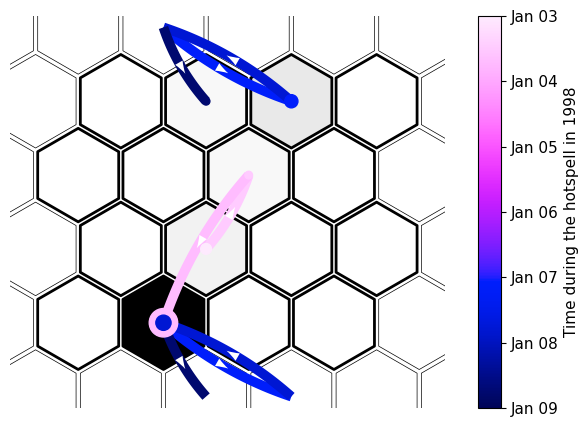

In [57]:
period = pd.date_range("19980103", "19980109", freq="6h")
splots.plt_traj_hotspell(nx, ny, period, labels)

In [ ]:
import matplotlib.lines as mlines
import itertools
param_sets = [
    (18, 0.3, 0.5),
    (20, 0.5, 0.5),
    (22, 0.5, 0.7),
]
colors = ["blue", "green", "red"]

proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=proj))
ax.coastlines()
#ax.set_global()
ax.set_extent([100, 200, 10, 75], crs=proj)

for (b, a, i), c in zip(param_sets, colors):
    jets = find_all_jets(ds_center, base_s_thresh=b, alignment_thresh=a, int_thresh_factor=i)
    for _, jet in jets.group_by(["cluster", "jet ID"], maintain_order=True):
        ax.plot(
            *jet[["lon", "lat"]].to_numpy().T,
            color=c, lw=2, alpha=0.5,
            transform=ccrs.PlateCarree()
        )

legend_handles = [
    mlines.Line2D([], [], color=c, lw=3, label=f"base_s={b}, align={a}, int={i}")
    for (b, a, i), c in zip(param_sets, colors)
]

ax.legend(
    handles=legend_handles,
    title="Threshold Parameters",
    loc="lower left",
    frameon=True,
    fontsize=9,
    title_fontsize=10
)

#ax.legend(colors, [f"base_s={b}, align={a}, int={i}" for b,a,i in param_sets], loc="lower left")
ax.set_title("Jet detection sensitivity to threshold parameters", fontsize=13)
plt.show()


In [ ]:
base_s = 20
align_values = [0.2, 0.5, 0.9]
int_values = [0.1, 0.5, 0.9]

proj = ccrs.PlateCarree(central_longitude=180)
fig, axes = plt.subplots(
    len(align_values), len(int_values),
    figsize=(14, 10),  # nice big panels
    subplot_kw=dict(projection=proj),
    constrained_layout=True
)

for ax, (a, i) in zip(axes.flat, itertools.product(align_values, int_values)):
    jets = find_all_jets(
        ds_center,
        base_s_thresh=base_s,
        alignment_thresh=a,
        int_thresh_factor=i
    )

    ax.set_extent([120, 280, -10, 80], crs=proj)
    ax.coastlines(color="gray", linewidth=0.5)
    ax.set_title(f"align={a}, int={i}", fontsize=10)
    ax.set_xticks([]); ax.set_yticks([])

    for _, jet in jets.group_by(["cluster", "jet ID"], maintain_order=True):
        ax.plot(*jet[["lon", "lat"]].to_numpy().T,
                color="royalblue", lw=1.2, alpha=0.7,
                transform=ccrs.PlateCarree())

fig.suptitle(f"Jet Detection Sensitivity (base_s={base_s})", fontsize=16, fontweight="bold")
plt.show()

/tmp/ipykernel_872254/134105596.py:8: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in range(ds_center.dims['cluster']):


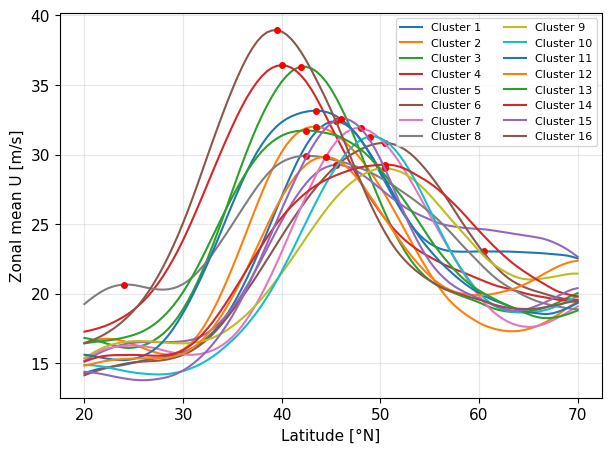

In [13]:
from scipy.signal import find_peaks

# compute zonal mean u for each cluster
u_zonal_mean = ds_center['s'].mean(dim='lon')

fig, ax = plt.subplots(figsize=(7, 5))

for i in range(ds_center.dims['cluster']):
    u_mean = u_zonal_mean.isel(cluster=i)
    lat = u_mean['lat'].values
    vals = u_mean.values

    # find peaks (require spacing and height)
    peaks, _ = find_peaks(vals, height=20, distance=5)  # tweak height, distance
    ax.plot(lat, vals, label=f"Cluster {i+1}")
    ax.plot(lat[peaks], vals[peaks], 'ro', ms=4)  # mark detected jets

ax.set_xlabel('Latitude [°N]')
ax.set_ylabel('Zonal mean U [m/s]')
ax.legend(ncol=2, fontsize=8)
ax.grid(True, alpha=0.3)
plt.show()

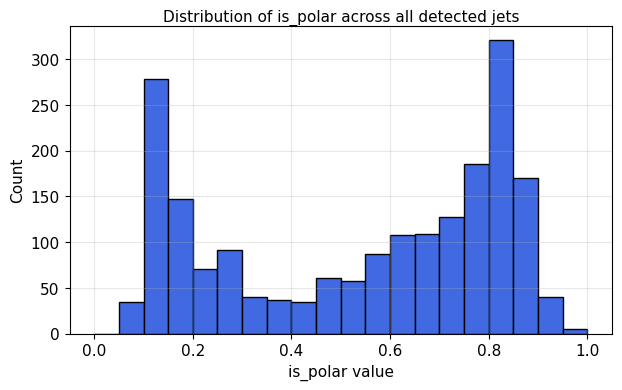

In [49]:
if isinstance(centers_all_jets, pl.DataFrame):
    df_plot = centers_all_jets.to_pandas()
else:
    df_plot = centers_all_jets.copy()

plt.figure(figsize=(7, 4))
plt.hist(df_plot["is_polar"], bins=np.linspace(0, 1, 21), color="royalblue", edgecolor="black")
plt.xlabel("is_polar value")
plt.ylabel("Count")
plt.title("Distribution of is_polar across all detected jets")
plt.grid(alpha=0.3)
plt.show()

In [44]:
da = exp_s.da
df = pd.read_csv(basepath + "/pnaz5001950.csv", delimiter=",")

index = pd.to_datetime(df.iloc[:, :3])
mask_time = (index >= "1959-01-01") & (index <= "2022-12-31")
index = index[mask_time]
values = df.iloc[:, 3].values[mask_time]

series = xr.DataArray(values, coords={"time": index}, dims="time", name="PNA")
#series = xr.DataArray(df.iloc[:, 3].values, coords={"time": index})
pna = series.interp_like(da)
pna_on_map = timeseries_on_map(pna, net.latest_bmus)[0]

yearly = mask_da.resample(time="1YE").sum().values
trends = np.zeros(net.n_nodes)
pvalues = trends.copy()
for k, yearly_ in enumerate(yearly.T):
    trends[k], _, _, pvalues[k], _ = linregress(
        np.arange(yearly.shape[0])[yearly_ != 0], yearly_[yearly_ != 0]
    )

X, da_weighted = exp_s.prepare_for_clustering()
da_weighted = coarsen_da(da_weighted, 3) #switched
X = da_weighted.data.reshape(exp_s.data_handler.get_flat_shape()[0], -1)
X, meanX, stX = normalize(X)
X = compute(X, progress_flag=True)

RMSE = np.zeros(net.n_nodes)
for i in trange(net.n_nodes):
    w = net.weights[i].flatten()[None, :]
    mask_ = labels.data == i
    x = X[mask_] .reshape(np.sum(mask_), -1) 
    RMSE[i] = np.mean(pairwise_distances(x, w))
    
separatedness = pairwise_distances(net.weights) / net.neighborhoods.distances
separatedness = np.nanmean(separatedness, axis=1)

100%|██████████| 16/16 [00:00<00:00, 40.89it/s]
/tmp/ipykernel_1320431/1988085909.py:35: RuntimeWarning: invalid value encountered in divide
  separatedness = pairwise_distances(net.weights) / net.neighborhoods.distances


In [ ]:
# calculate and save anomalies JJA and DJF
'''
seasonanom = 'DJF'
danom = xr.open_dataset("/scratch2/mabeling/data/ERA5/plev/high_wind/6H/z500data/combined/z500_1959_2022.nc")

if seasonanom in season_months:
    danom = danom.sel(time=danom["time"].dt.month.isin(season_months[seasonanom]))

danom = danom.assign_coords(lon=((danom.lon + 360) % 360)).sortby("lon")


# Daily climatology (here over all years)
clim = danom["z"].groupby("time.dayofyear").mean("time")

# 90-day running smoothing in the day-of-year dimension
clim_smooth = clim.rolling(dayofyear=90, center=True, min_periods=1).mean()

# Anomalies
danom["z_anom"] = danom["z"].groupby("time.dayofyear") - clim_smooth

# Verify
#print(float(ds["z_anom"].mean()), float(ds["z_anom"].std())) 
#-35.679... 744.849...

danom["z_anom"].to_netcdf(f"/scratch2/mabeling/data/ERA5/plev/high_wind/6H/z500data/combined/z500_pacific_anom_{seasonanom}_1959_2022_NEWLONS.nc",
    encoding={"z_anom": {"zlib": True, "complevel": 4}})
'''

In [ ]:
'''
dold = xr.open_dataset(f"/scratch2/mabeling/data/ERA5/plev/high_wind/6H/z500data/combined/z500_pacific_anom_{season}_1959_2022.nc")
dtest = xr.open_dataset(f"/scratch2/mabeling/data/ERA5/plev/high_wind/6H/z500data/combined/z500_pacific_anom_{season}_1959_2022_NEWLONS.nc")

print(dold.lon.values[:10]) 
print(dold.lon.values[-10:])
print(dtest.lon.values[:10]) 
print(dtest.lon.values[-10:])
'''

[120.  120.5 121.  121.5 122.  122.5 123.  123.5 124.  124.5]
[-84.5 -84.  -83.5 -83.  -82.5 -82.  -81.5 -81.  -80.5 -80. ]
[120.  120.5 121.  121.5 122.  122.5 123.  123.5 124.  124.5]
[275.5 276.  276.5 277.  277.5 278.  278.5 279.  279.5 280. ]


In [ ]:
dh = xr.open_dataset(f"/scratch2/mabeling/data/ERA5/plev/high_wind/6H/z500data/combined/z500_pacific_anom_{season}_1959_2022_NEWLONS.nc")
print(dh.lon.values[:5], "...", dh.lon.values[-5:])
lon = dh.lon.values
print(lon[:10], "...", lon[-10:])

# check that differences are roughly uniform
diffs = np.diff(lon)
print("Δlon stats → min:", diffs.min(), "max:", diffs.max())
is_monotonic = np.all(np.diff(lon) > 0)
print("Longitudes monotonic:", is_monotonic)
has_jump = np.any(np.abs(np.diff(np.unwrap(np.deg2rad(lon)))) > np.deg2rad(10))
print("Longitude discontinuity detected:", has_jump)
# Compute longitude diffs in a circular sense
diffs_wrapped = np.diff(np.mod(lon + 180, 360))
print("Δlon wrapped stats → min:", diffs_wrapped.min(), "max:", diffs_wrapped.max())

lon = dh.lon.values
diffs_wrapped = np.diff(np.mod(lon + 180, 360))

jump_indices = np.where(diffs_wrapped > 5)[0]  # any big gap
for i in jump_indices:
    print(f"Jump between lon[{i}]={lon[i]} and lon[{i+1}]={lon[i+1]}  (Δ={diffs_wrapped[i]:.1f}°)")

[120.  120.5 121.  121.5 122.  122.5 123.  123.5 124.  124.5] ... [275.5 276.  276.5 277.  277.5 278.  278.5 279.  279.5 280. ]
Δlon stats → min: 0.5 max: 0.5
Longitudes monotonic: True
Longitude discontinuity detected: False
Δlon wrapped stats → min: -359.5 max: 0.5


In [ ]:
print(season) # JJA anomalies experiment 8!!! DJF 12
dh = xr.open_dataset(f"/scratch2/mabeling/data/ERA5/plev/high_wind/6H/z500data/combined/z500_pacific_anom_{season}_1959_2022_NEWLONS.nc")

# convert geopotential (m**2 s**-2) in height (m)
g = 9.80665
dh["z_anom_m"] = dh["z_anom"] / g
dh["z_anom_m"].attrs["units"] = "m"
dh["z_anom_m"].attrs["long_name"] = "500 hPa geopotential height anomaly (m)"
z_anom = dh["z_anom_m"]


coslat = np.cos(np.deg2rad(z_anom.lat))
sqrtcoslat = np.sqrt(coslat)
z_weighted = z_anom * sqrtcoslat

exp_z = Experiment(DataHandler.from_basepath_and_da(basepath, z_weighted, save_da=True))
print(exp_z.path)


# Perform K-means 
centers_z, labels_z = exp_z.do_kmeans(4, 40, weigh_grams=False)

coslat = np.cos(np.deg2rad(centers_z.lat))
Pwr = (exp_z.da * centers_z * coslat).sum(["lon", "lat"]) / coslat.sum() / centers_z.lon.shape[0]

Iwr = (Pwr - Pwr.mean("time")) / Pwr.std("time", ddof=0)
Iwr = compute(Iwr)
Iwr = xarray_to_polars(Iwr.rename("Iwr")).drop("ratio", "label")

# Iwr = Iwr.with_columns(year=pl.col("time").dt.year())
thr_factor = 1  # 0.5 x standard deviation 
thr = thr_factor * Iwr["Iwr"].std()
#sigma_wr = Iwr["Iwr"].std()
winner = Iwr.group_by("time", maintain_order=True).agg(pl.col("Iwr").arg_max().alias("winner"), pl.col("Iwr").max(), pl.col("time").dt.year().alias("year").first())
winner = winner.with_columns(winner=pl.when(pl.col("Iwr") > thr).then(1 + pl.col("winner")).otherwise(pl.lit(0)))
start_of_year = winner.group_by("year", maintain_order=True).len().with_columns(start_of_year=pl.col("len").cum_sum() - pl.col("len").get(0)).drop("len")

to_zero = (
    winner
    .group_by("year", maintain_order=True)
    .agg(pl.col("winner").rle().alias("rle"))
    .explode("rle")
    .unnest("rle")
    .group_by("year", maintain_order=True)
    .agg(
        len=pl.col("len"),
        start=pl.lit(0).append(
            pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)
        ),
        value=pl.col("value"),
    )
    .explode(["len", "start", "value"])
    .join(start_of_year, on="year")
    .with_columns(start=pl.col("start") + pl.col("start_of_year"))
    .drop("start_of_year")
    .filter(pl.col("len") < 20, pl.col("value") > 0)
    .drop("value")
    .with_columns(
        index=pl.int_ranges(pl.col("start"), pl.col("start") + pl.col("len"))
    )
    .drop("len", "start")
    .explode("index")
)[:, "index"]
winner[to_zero, "winner"] = 0

mask_updated = labels_to_mask(winner[:, "winner"].to_numpy())

s_and_z = (mask[:, :, None] & mask_updated[:, None, :])

DJF
/scratch2/mabeling/data/ERA5/plev/high_wind/6H/data/combined/12


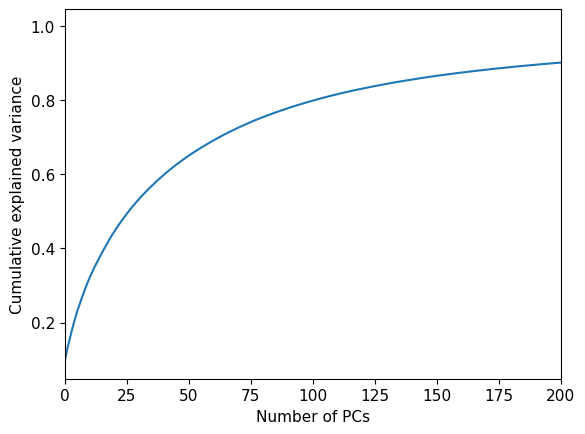

In [92]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,200)
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative explained variance')
plt.show()

In [22]:
for t in [0.1, 0.2, 0.4, 0.5, 1.0]:
    frac = (Iwr["Iwr"] > t).mean()
    print(f"Fraction above {t}: {frac:.2f}")

Fraction above 0.1: 0.46
Fraction above 0.2: 0.42
Fraction above 0.4: 0.35
Fraction above 0.5: 0.32
Fraction above 1.0: 0.17


Text(0, 0.5, 'Count')

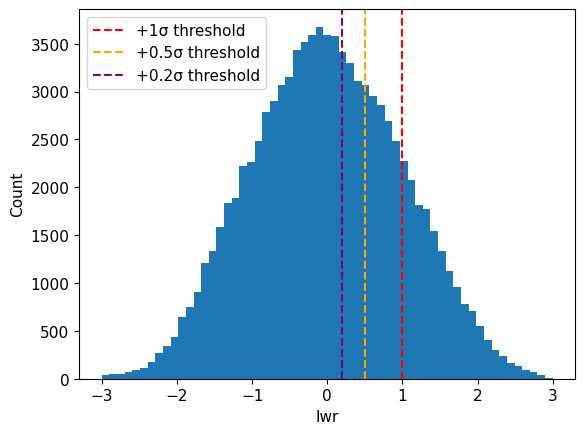

In [23]:
plt.hist(Iwr["Iwr"], bins=np.linspace(-3,3,60))
plt.axvline(1, color="r", ls="--", label="+1σ threshold")
plt.axvline(0.5, color="orange", ls="--", label="+0.5σ threshold")
plt.axvline(0.2, color="purple", ls="--", label="+0.2σ threshold")
plt.legend(); plt.xlabel("Iwr"); plt.ylabel("Count")

In [44]:
Iwr_stats = Iwr.describe()
print(Iwr_stats)

shape: (9, 5)
┌────────────┬─────────────────────┬─────────┬─────────┬────────────┐
│ statistic  ┆ time                ┆ cluster ┆ level   ┆ Iwr        │
│ ---        ┆ ---                 ┆ ---     ┆ ---     ┆ ---        │
│ str        ┆ str                 ┆ f64     ┆ f64     ┆ f64        │
╞════════════╪═════════════════════╪═════════╪═════════╪════════════╡
│ count      ┆ 94208               ┆ 94208.0 ┆ 94208.0 ┆ 94208.0    │
│ null_count ┆ 0                   ┆ 0.0     ┆ 0.0     ┆ 0.0        │
│ mean       ┆ 1991-01-15 15:00:00 ┆ 1.5     ┆ 500.0   ┆ 1.5447e-16 │
│ std        ┆ null                ┆ 1.11804 ┆ 0.0     ┆ 1.000005   │
│ min        ┆ 1959-06-01 00:00:00 ┆ 0.0     ┆ 500.0   ┆ -3.84685   │
│ 25%        ┆ 1975-06-01 00:00:00 ┆ 1.0     ┆ 500.0   ┆ -0.7018    │
│ 50%        ┆ 1991-06-01 00:00:00 ┆ 2.0     ┆ 500.0   ┆ -0.004418  │
│ 75%        ┆ 2006-08-31 18:00:00 ┆ 2.0     ┆ 500.0   ┆ 0.70164    │
│ max        ┆ 2022-08-31 18:00:00 ┆ 3.0     ┆ 500.0   ┆ 3.795164   │
└─────

In [46]:
titles_wr = [
    "PNA-",
    "AL",
    "AR",
    "PNA+",
    "No regime",
]
letters_wr = list("efghi")
order_to_plot = [1, 2, 3, 4, 0]
titles_wr_with_props = [f"{letter}) {title} (${prop * 100:.1f} \%$)" for letter, title, prop in zip(list("efghi"), titles_wr, mask_updated.mean(axis=0)[order_to_plot])]
s_and_z_means = s_and_z.mean(axis=0) / mask.mean(axis=0)[:, None]
s_and_z_means = s_and_z_means[:, order_to_plot]
majority = np.argmax(s_and_z_means[:, :4], axis=1)
no_regime = mask_updated.mean(axis=0)[0]

<>:10: SyntaxWarning: invalid escape sequence '\%'
<>:10: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_1320431/1536831200.py:10: SyntaxWarning: invalid escape sequence '\%'
  titles_wr_with_props = [f"{letter}) {title} (${prop * 100:.1f} \%$)" for letter, title, prop in zip(list("efghi"), titles_wr, mask_updated.mean(axis=0)[order_to_plot])]


In [47]:
titles_wr_with_props

['e) PNA- ($15.4 \\%$)',
 'f) AL ($15.0 \\%$)',
 'g) AR ($13.8 \\%$)',
 'h) PNA+ ($15.8 \\%$)',
 'i) No regime ($40.0 \\%$)']

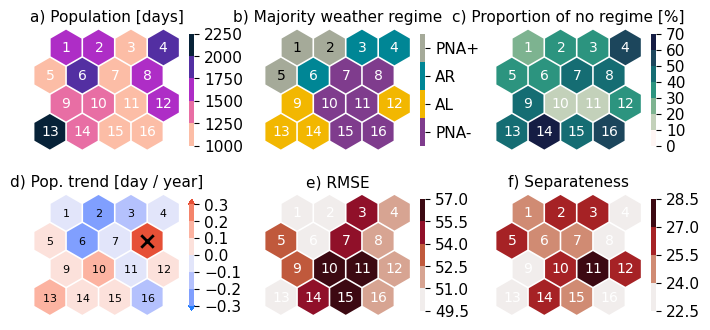

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(TEXTWIDTH_IN , 2 * 1.8), tight_layout=True, subplot_kw=dict(aspect="equal"))

to_plot_dict = {
    "a) Population [days]": (populations, colormaps.bubblegum_r, True, True, {}),
    "b) Majority weather regime": (majority, colormaps.bold, False, True, {"ticks": np.arange(4), "ticklabels": titles_wr[:-1], "boundaries": np.arange(-0.5, 4.5)}),
    "c) Proportion of no regime [%]": (s_and_z_means[:, -1] * 100, colormaps.tempo, BoundaryNorm(np.arange(0, 80, 10), colormaps.tempo.N, extend="neither"), True, {}),
    "d) Pop. trend [day / year]": (trends, colormaps.cet_d_bwr, BoundaryNorm(np.linspace(-0.3, 0.3, 7), colormaps.cet_d_bwr.N, extend="both"), False, {}),
    "e) RMSE": (RMSE, colormaps.amp, True, True, {}),
    "f) Separateness" : (separatedness, colormaps.amp, True, True, {}),
} 
for ax, (title, to_plot) in zip(axes.ravel(), to_plot_dict.items()):
    to_plot, cmap, discretify, numbering, more_cbar_kwargs = to_plot
    if isinstance(discretify, bool):
        discretify = discretify
        norm = None
    else:
        norm = discretify
        discretify = False
    fig, ax = net.plot_on_map(
        to_plot,
        fig=fig,
        ax=ax,
        cmap=cmap,
        norm=norm,
        discretify=discretify,
        numbering=numbering,
        cbar_kwargs={"shrink": 0.7} | more_cbar_kwargs
    )
    ax.set_title(title)
    
coords = net.neighborhoods.coordinates
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
ax = axes.ravel()[3]
ax.scatter(*signif.T, s=80, c="black", marker="x", linewidths=2.)
for i, c in enumerate(coords):
    x, y = c
    if i in where_signif:
        continue
    ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="black", fontsize=8)
plt.savefig(f"/home/mabeling/MasterThesis/plots/som/SOM_6_{season}_regimenrs.pdf", bbox_inches="tight", pad_inches=0.1)

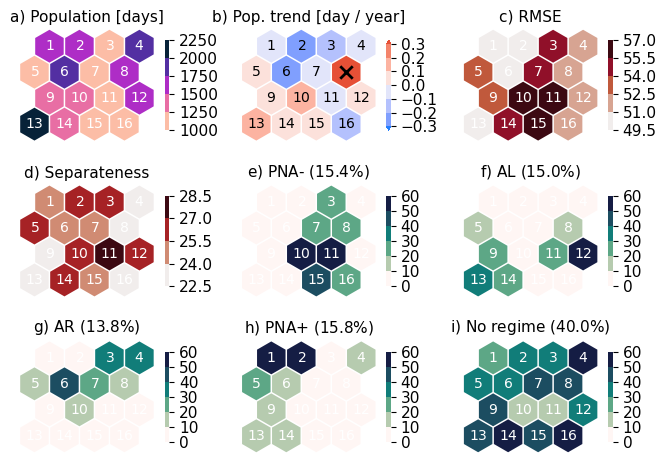

In [50]:
fig, axes = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 3 * 1.6), tight_layout=True, subplot_kw=dict(aspect="equal"))

to_plot_dict = {
    "a) Population [days]": (populations, colormaps.bubblegum_r, True, True),
    "b) Pop. trend [day / year]": (trends, colormaps.cet_d_bwr, BoundaryNorm(np.linspace(-0.3, 0.3, 7), colormaps.cet_d_bwr.N, extend="both"), False),
    "c) RMSE": (RMSE, colormaps.amp, True, True),
    "d) Separateness" : (separatedness, colormaps.amp, True, True),
} | {
    title_wr: (this_sz * 100, colormaps.tempo, BoundaryNorm(np.arange(0, 65, 10), colormaps.tempo.N, extend="neither"), True) for title_wr, this_sz in zip(titles_wr_with_props, s_and_z_means.T)
}
for ax, (title, to_plot) in zip(axes.ravel(), to_plot_dict.items()):
    to_plot, cmap, discretify, numbering = to_plot
    if isinstance(discretify, bool):
        discretify = discretify
        norm = None
    else:
        norm = discretify
        discretify = False
    fig, ax = net.plot_on_map(
        to_plot,
        fig=fig,
        ax=ax,
        cmap=cmap,
        norm=norm,
        discretify=discretify,
        numbering=numbering,
        cbar_kwargs={"shrink": 0.75}
    )
    ax.set_title(title)
    
coords = net.neighborhoods.coordinates
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
ax = axes.ravel()[1]
ax.scatter(*signif.T, s=80, c="black", marker="x", linewidths=2.)
for i, c in enumerate(coords):
    x, y = c
    if i in where_signif:
        continue
    ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="black", fontsize=10)
plt.savefig(f"/home/mabeling/MasterThesis/plots/som/SOM_9_{season}_regimenrs.pdf", bbox_inches="tight", pad_inches=0.1)

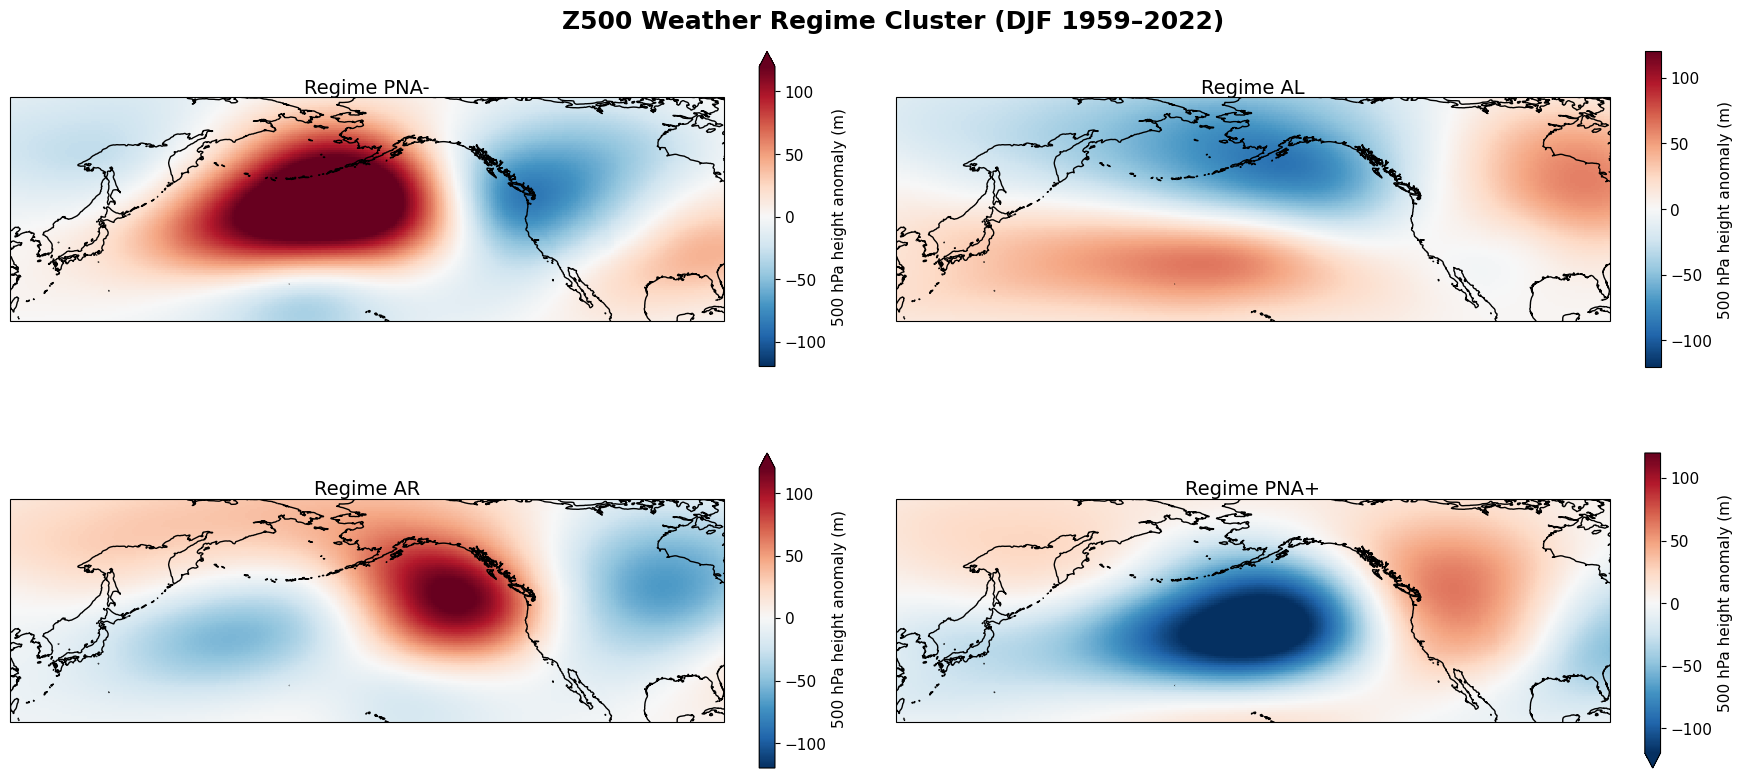

In [52]:
fig, axes = plt.subplots(
    2, 2,
    figsize=(18, 10),
    subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180))
)

centers_z = centers_z.sortby("lon")

for i, ax in enumerate(axes.flat):
    centers_z.isel(cluster=i).plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        vmin=-120, vmax=120,
        center=0,
        robust=True,
        cbar_kwargs={"shrink": 0.6, "pad": 0.04, "label": "500 hPa height anomaly (m)"}
    )
    ax.coastlines()
    ax.set_title(f"Regime {titles_wr[i]}", fontsize=14)
    ax.set_extent([120, 280, 20, 70], crs=ccrs.PlateCarree())
fig.suptitle(f"Z500 Weather Regime Cluster ({season} 1959–2022)",
             fontsize=18, fontweight="bold", y=0.88)
plt.tight_layout()
plt.savefig(f"/home/mabeling/MasterThesis/plots/som/Regimes_{season}_regimenrs.pdf", bbox_inches="tight", pad_inches=0.1)#, orientation="landscape")
plt.show()
# PNA+ PNA-
# Alaskan ridge; Alaskan trough 
# Arctic low; Arctic High (~Greenland High) aleutian Low

#JJA
# Regime 0: Pacific trough
# Regime 1: ? Alaskan Ridge (Naz +  Liu) greenland high (Lee)
# Regime 2: ? Maybe arctic high? (\liu et al) naz says no; lee nothing
# Regime 3: PNA-  (or A+ (Naz) pacific ridge (lee maybe lui)


# DJF
# Regime 0: PNA-  or Pacific ridge (Lee)       or Arctic low?
# Regime 1: Pacific trough/ winter aleutian low
# Regime 2: Alaskan ridge
# Regime 3: ? PNA+ or Arctic high

# Arctic high = greenland high?
# pacific trough =  winter! aleutian low?


#old
# Regime 0: ? PNA+ or greenland high
# Regime 1: Pacific ridge (PNA+ or Alaskan ridge  or Arctic low)
# Regime 2: Alaskan ridge (PNA- or Artic High)
# Regime 3: summer trough? MJO?

## Typical summer pathway

In [53]:
timestepwise = []
group = [] 
for i, (_, group_) in enumerate(labels.groupby(labels.time.dt.dayofyear).groups.items()):
    group.append(group_)
    if i % 7 != 6:
        continue
    group = np.concatenate(group)
    coords = net.neighborhoods.coordinates[labels[group]]
    unique, count = np.unique(labels[group], return_counts=True)
    
    coordsmax = coords.max(axis=0, keepdims=True)
    thetas = coords / coordsmax * 2 * np.pi
    xi, zeta = np.cos(thetas), np.sin(thetas)
    mxi, mzeta = np.mean(xi, axis=0), np.mean(zeta, axis=0)
    com = np.arctan2(-mzeta, -mxi) + np.pi
    com = com / 2 / np.pi * coordsmax
    
    maxdx = net.x
    maxdy = net.y
    dx = np.abs(coords[:, 0] - com[0, 0])
    dy = np.abs(coords[:, 1] - com[0, 1])
    mask_periodic = dx > maxdx
    dx[mask_periodic] = maxdx - dx[mask_periodic]
    mask_periodic = dy > maxdy
    dy[mask_periodic] = maxdy - dy[mask_periodic]
    stdx = np.sqrt(np.sum(dx ** 2) / (len(dx) - 1))
    stdy = np.sqrt(np.sum(dy ** 2) / (len(dy) - 1))
    variab = np.asarray([stdx, stdy])
    timestepwise.append((com.squeeze(), variab.squeeze(), unique, count))
    group = []
    
com = np.asarray([step_[0] for step_ in timestepwise])
com_std = np.asarray([step_[1] for step_ in timestepwise])

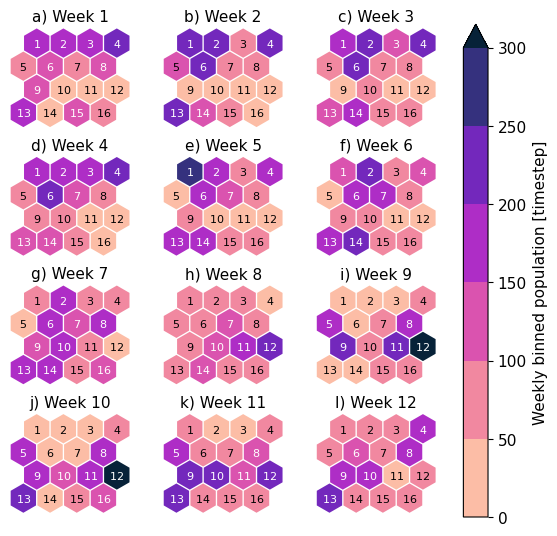

In [54]:
fig, axes = plt.subplots(4, 3, figsize=(TEXTWIDTH_IN, 6.4), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
max_ = np.quantile([np.amax(timestepwis[3]) for timestepwis in timestepwise], 0.8)
#norm = BoundaryNorm(MaxNLocator(6).tick_values(0, max_), cmap.N, extend="max")
norm = BoundaryNorm(MaxNLocator(6).tick_values(0, max_), cmap.N, extend="max")

im = ScalarMappable(norm, cmap)
coords = net.neighborhoods.coordinates
cbar = fig.colorbar(im, ax=axes)
cbar.ax.set_ylabel("Weekly binned population [timestep]")
for i, ax in enumerate(axes.ravel()):
    step = i + 1
    letter = ascii_lowercase[i]
    unique, counts = timestepwise[step][2], timestepwise[step][3]
    to_plot = np.zeros(net.n_nodes)
    to_plot[unique] = counts
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
        linewidths=0,
    )
    # ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"{letter}) Week {step}", pad=2)
    
    for i, c in enumerate(coords):
        x, y = c
        color = "white" if to_plot[i] > 100 else "black"
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color=color, fontsize=8)
fig.set_tight_layout(False)
plt.savefig(f"/home/mabeling/MasterThesis/plots/som/Weekly_pathway_{season}.pdf", bbox_inches="tight", pad_inches=0.1)